In [1]:
import os
import json
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import metrics
import pandas as pd

In [2]:
# This more Numpy heavy method takes 60% of the time and less memory
def scalepose(pose):
    keypoints = np.array([x for x in pose.values()])
    means = np.array([np.mean(keypoints[:,0]),np.mean(keypoints[:,1])])
    stds = np.array([np.std(keypoints[:,0]),np.std(keypoints[:,1])])
    if stds.sum() == 0.0: return keypoints # Bail out on an empty Skeleton
    keypoints = (keypoints.T - means[:,None]) / stds[:,None]
    return keypoints.T

def pose_report(model, compare = False):
    pred = [labels[i] for i in model.predict(X_test)]
    truth = [labels[i] for i in y_test]
    f1 = metrics.f1_score(truth,pred,average='micro')
    #roc = metrics.roc_auc_score(truth,pred)
    print(f'Model = {model}\nF1 score = {f1}')
    if compare:
        file = open("best.pkl",'rb')
        best = pickle.load(file)
        file.close()
        best_pred = [labels[i] for i in best.predict(X_test)]
        best_f1 = metrics.f1_score(truth, best_pred, average='micro')
        if f1 > best_f1:
            fileobject = open("best.pkl","wb")
            pickle.dump(model,fileobject)
            print("New best performance!")
        else: print(f"No improvement over current best: {best_f1}")
    confMatrix(truth,pred)

def confMatrix(truth: list, predictions: list, log = False):
    '''
    predictions, truth as lists of values.
    Class names and quantity calculated automatically from unique values across both lists.
    Set log to True for a logarithmic colour map - good for high performing classifiers.
    '''
    classnames = sorted(list(set(list(truth) + list(predictions)))) #Produces sorted list of unique classnames
    if log: norm = matplotlib.colors.LogNorm()
    else:   norm = matplotlib.colors.Normalize()
    matrix = pd.DataFrame(metrics.confusion_matrix(truth, predictions),
                      index = classnames,
                      columns = classnames)
    
    fig = plt.figure(figsize = (10,8))
    heatmap = sns.heatmap(matrix, annot = True, fmt = "d",
                          cmap = "rocket_r", square = True,
                          vmin = 0.001,# Zero value catcher for LogNorm
                          norm = norm)
 
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation = 0, ha = 'right', fontsize = 14)
   
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation = 0, ha = 'right', fontsize = 14)
  
    # Corrects ylim issues under matplotlib 3.1.1. Comment this out if not required.
    if matplotlib.__version__ == '3.1.1':
        plt.ylim(len(classnames),0)
        print("Note: Matplotlib version 3.1.1 has some compatability issues with Seaborn.")
   
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
labels = ['Correct','Incorrect','Nonlifting']

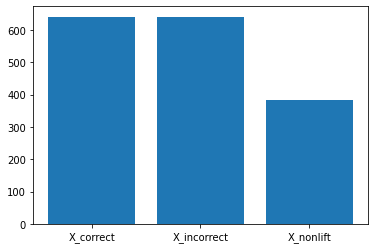

In [4]:
resultdir = '/home/mscai/gdp/test_images/'
folders = ["X_correct", 
           "X_incorrect", 
           "X_nonlift", 
           #"X_mixed"
          ]
fullfolders = [os.path.join(resultdir, f) for f in folders]
testfiles = list()
for folder in fullfolders:
    testfiles += [os.path.join(folder,f) for f in os.listdir(folder) if f.split('.')[-1] == 'json']

plt.bar([0,1,2],[len(os.listdir(folder))/2 for folder in fullfolders])
plt.xticks([0,1,2],folders)
plt.show()

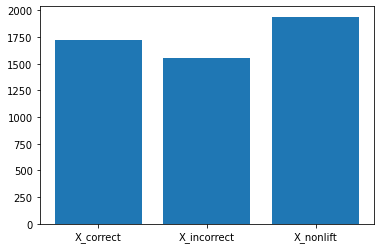

In [5]:
resultdir = '/home/mscai/gdp/training_images/'
folders = ["X_correct", 
           "X_incorrect", 
           "X_nonlift", 
           #"X_mixed"
          ]
fullfolders = [os.path.join(resultdir, f) for f in folders]
trainfiles = list()
for folder in fullfolders:
    trainfiles += [os.path.join(folder,f) for f in os.listdir(folder) if f.split('.')[-1] == 'json']

plt.bar([0,1,2],[len(os.listdir(folder))/2 for folder in fullfolders])
plt.xticks([0,1,2],folders)
plt.show()

In [6]:
X_train = list()
y_train = list()

for file in trainfiles:
    try:
        with open(file) as jsonFile:
            posedict = json.load(jsonFile)
            jsonFile.close()
    except: print(f"Error in {file}")
    people = posedict.keys()
    for p in people:
        pose = posedict[p]['skeleton']
        if np.count_nonzero(np.array([x for x in posedict[p]['skeleton'].values()])) >= 6:
            X_train.append(scalepose(posedict[p]['skeleton']).flatten())
            y_train.append(posedict[p]['category'])
        
print(len(X_train))
print(len(y_train))

4577
4577


In [7]:
X_test = list()
y_test = list()

for file in testfiles:
    try:
        with open(file) as jsonFile:
            posedict = json.load(jsonFile)
            jsonFile.close()
    except: print(f"Error in {file}")
    people = posedict.keys()
    for p in people:
        pose = posedict[p]['skeleton']
        if np.count_nonzero(np.array([x for x in posedict[p]['skeleton'].values()])) >= 6:
            X_test.append(scalepose(posedict[p]['skeleton']).flatten())
            y_test.append(posedict[p]['category'])
        
print(len(X_test))
print(len(y_test))


1514
1514


Model = SVC()
F1 score = 0.8137384412153237


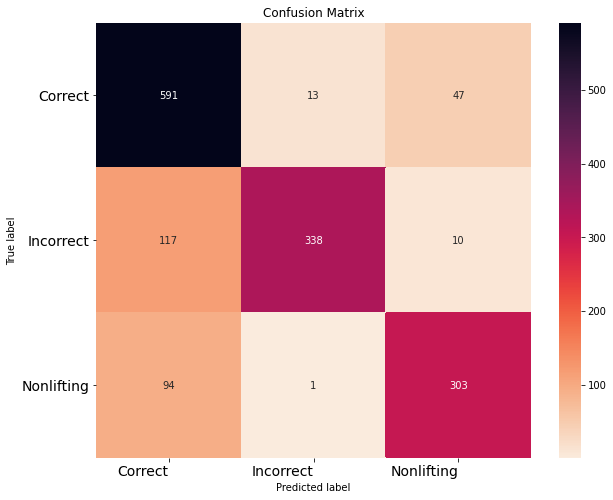

In [9]:
from sklearn import svm
model = svm.SVC()
model.fit(X_train,y_train)
pose_report(model)



Model = KNeighborsClassifier()
F1 score = 0.7813738441215323
No improvement over current best: 0.8137384412153237


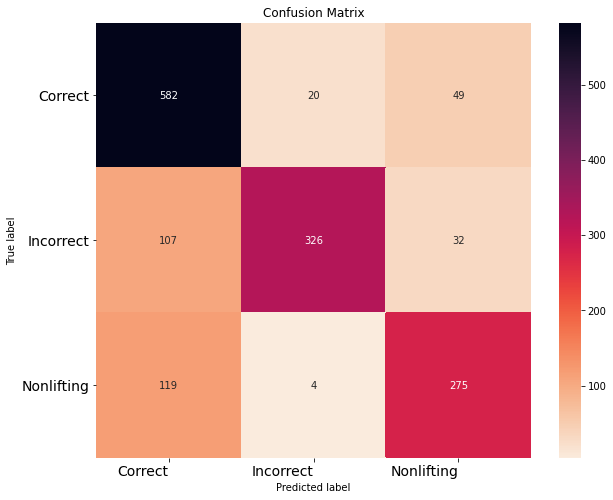

In [13]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train,y_train)
pose_report(model, compare = True)

Model = RandomForestClassifier()
F1 score = 0.8474240422721269
New best performance!


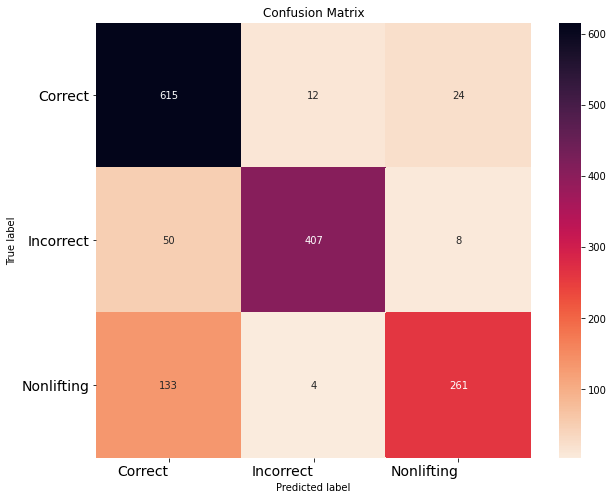

In [15]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
pose_report(model, compare = True)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('rfc', RandomForestClassifier(random_state=0)),
    ])


params = {
        'pfs__degree' : (1,2),
        'rfc__n_estimators':(200,300),
        'rfc__criterion':('gini','entropy'),
        'rfc__max_depth':(15,25,35),
        'rfc__class_weight':(['balanced'])
         }

gs = GridSearchCV(
                pipeline,
                params,
                verbose=20,
                n_jobs=-1,
                scoring='f1_micro'
                ).fit(X_train,y_train)

pose_report(gs.best_estimator_, compare = True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Model = SVC(degree=4, kernel='poly', random_state=0)
F1 score = 0.8249669749009247


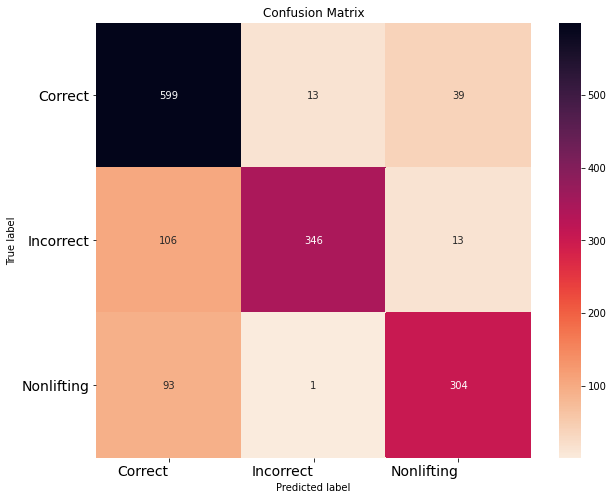

In [18]:
from sklearn.model_selection import GridSearchCV

params = {
        'kernel' : (['poly']),
        'degree' : (2,3,4,5),
         }

gs = GridSearchCV(
                svm.SVC(random_state=0),
                params,
                verbose=20,
                n_jobs=-1,
                scoring='f1_micro'
                ).fit(X_train,y_train)

pose_report(gs.best_estimator_)

Model = SVC(degree=4, kernel='poly', random_state=0)
F1 score = 0.8249669749009247


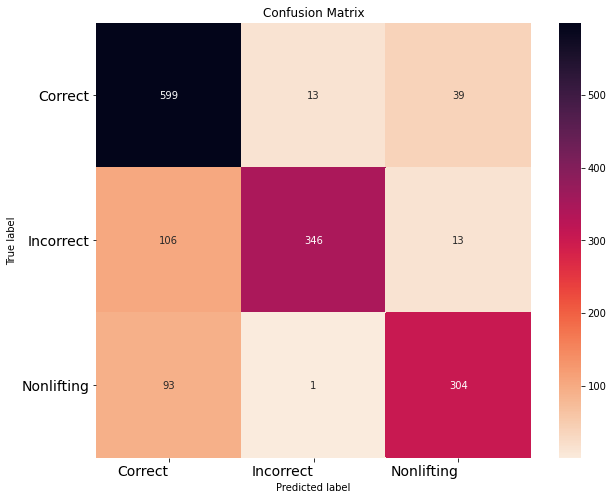

In [9]:
model = svm.SVC(random_state=0,kernel='poly',degree=4).fit(X_train,y_train)
pose_report(model)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model = Pipeline(steps=[('pfs', PolynomialFeatures()),
                ('svc', SVC(kernel='linear', random_state=0))])
F1 score = 0.8553500660501983


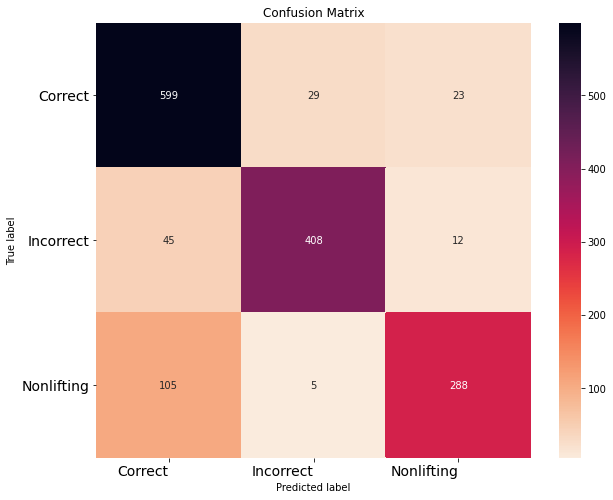

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('svc', svm.SVC(random_state=0)),
    ])

params = {
        'pfs__degree' : (2,3),
        'svc__kernel' : ('linear','rbf','sigmoid'),
         }

gs = GridSearchCV(
                pipeline,
                params,
                verbose=20,
                n_jobs=-1,
                scoring='roc_auc'
                ).fit(X_train,y_train)

pose_report(gs.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Model = Pipeline(steps=[('pfs', PolynomialFeatures()), ('pca', PCA(n_components=0.9)),
                ('svc', NuSVC(nu=0.1, random_state=0))])
F1 score = 0.8421400264200792


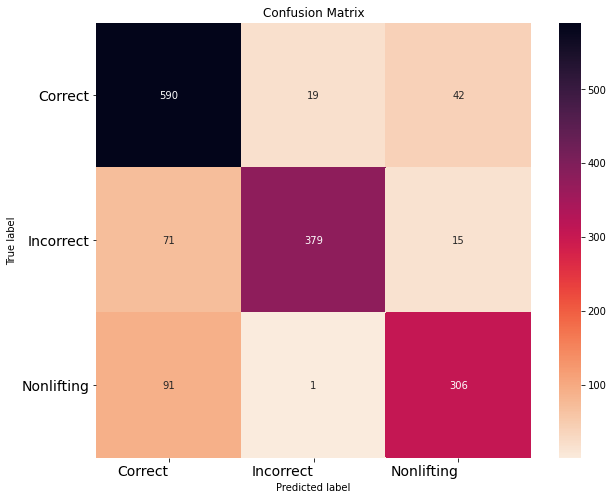

In [19]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

pipeline = Pipeline([
    ('pfs', PolynomialFeatures()),
    ('pca', PCA()),
    ('svc', svm.NuSVC(random_state=0)),
    ])

params = {
        'pfs__degree' : (1,2),
        'svc__kernel' : (['rbf']),
        'pca__n_components' : (0.9,0.8),
        'svc__nu' : ([(x+1)/30 for x in range(5)])
         }

gs = GridSearchCV(
                pipeline,
                params,
                verbose=20,
                n_jobs=-1,
                scoring='f1_micro'
                ).fit(X_train,y_train)

pose_report(gs.best_estimator_, compare = True)

In [20]:
print(gs.best_estimator_)
print(metrics.classification_report(y_test,gs.best_estimator_.predict(X_test)))

Pipeline(steps=[('pfs', PolynomialFeatures()),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced', max_depth=25,
                                        n_estimators=200, random_state=0))])
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       651
           1       0.97      0.89      0.93       465
           2       0.90      0.69      0.78       398

    accuracy                           0.86      1514
   macro avg       0.89      0.84      0.86      1514
weighted avg       0.87      0.86      0.86      1514



In [19]:
fileobject = open(b"poseclass_rfc.pkl","wb")
pickle.dump(gs.best_estimator_,fileobject)

Model = Pipeline(steps=[('pfs', PolynomialFeatures()),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced', max_depth=25,
                                        n_estimators=200, random_state=0))])
F1 score = 0.8639365918097754


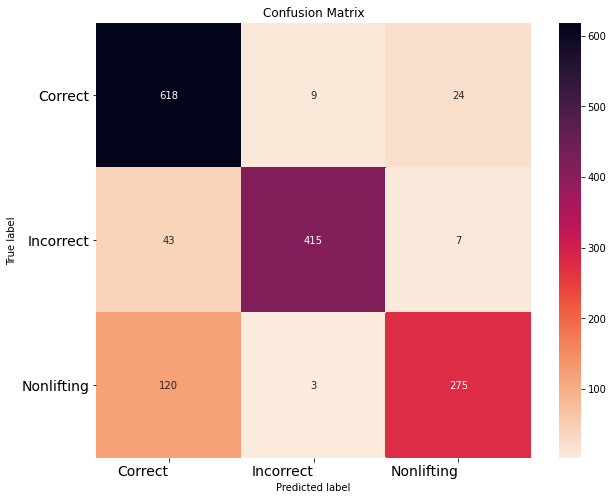

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       651
           1       0.97      0.89      0.93       465
           2       0.90      0.69      0.78       398

    accuracy                           0.86      1514
   macro avg       0.89      0.84      0.86      1514
weighted avg       0.87      0.86      0.86      1514



In [10]:
file = open("best.pkl",'rb')
model = pickle.load(file)
file.close()

pose_report(model,compare=False)

pred = model.predict(X_test)
from sklearn.metrics import classification_report

print(classification_report(y_test,pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Model = MLPClassifier(early_stopping=True, hidden_layer_sizes=[256, 256], max_iter=500,
              random_state=0)
F1 score = 0.8196829590488771
No improvement over current best: 0.8639365918097754


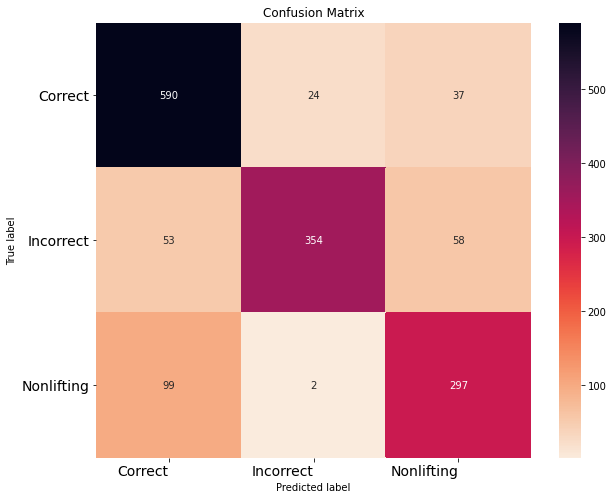

In [14]:

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

params = {
        'hidden_layer_sizes' : ([64,64,64],[128,128,128],[256,256],[512,512]),
        'activation' : ('tanh','relu','logistic'),
         }

gs = GridSearchCV(
                MLPClassifier(random_state = 0,
                              solver = 'adam',
                              max_iter = 500,
                              early_stopping = True),
                params,
                verbose=20,
                n_jobs=-1,
                scoring='f1_micro'
                ).fit(X_train,y_train)

pose_report(gs.best_estimator_, compare = True)

## Binary Experiment

In [33]:
ybin_test = [int(val==1) for val in y_test]
ybin_train = [int(val==1) for val in y_train]

0.9537648612945839


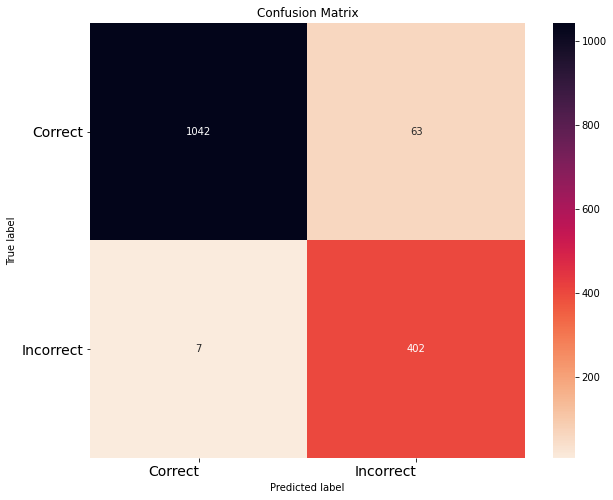

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ('pfs', PolynomialFeatures(2)),
    ('rfc', RandomForestClassifier(random_state=0)),
    ]).fit(X_train,ybin_train)

labels = ['Correct','Incorrect','Nonlifting']
pred = [labels[i] for i in model.predict(X_test)]
truth = [labels[i] for i in ybin_test]
f1 = metrics.f1_score(truth,pred,average='micro')
print(f1)
confMatrix(pred,truth)

In [39]:
fileobject = open(b"binary_class.pkl","wb")
pickle.dump(model,fileobject)